In [60]:
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
# import loompy
# import anndata

# make the notebook work from both Yike and Fabio's computers
# os.path.isdir: This method returns True if specified path is an existing directory, otherwise returns False
if os.path.isdir('/home/yike'):
    root_data_fdn = '/home/yike/phd/dengue/data/'
elif os.path.isdir('/home/fabio'):
    root_data_fdn = '/home/fabio/university/PI/projects/Yike_repos/dengue/data/'
else:
    raise RuntimeError('I do not know what computer we are on! Where are the data located?')

adata = sc.read_h5ad(root_data_fdn + 'mergedata_20200930_high_quality.h5ad')
adata=adata[adata.obs['cell_quality']=='high']
adata.obs['dataset'] = adata.obs['platform'].replace({
           '10X': 'children',
            'plate':'adult'   
        })

Trying to set attribute `.obs` of view, copying.


In [61]:
# adatad_by_condition[('children', 'dengue', 'B_cells')]
def adata_triple(adata):
    cell_types = ['B_cells', 'NK_cells', 'T_cells', 'Monocytes', 'Plasmablasts', 'pDCs', 'cDCs']
    conditions = ['S_dengue', 'dengue', 'Healthy', 'DWS']
    # cell_types = list(adata.obs['cell_type'].cat.categories)
    datasets=['children','adult']
    adatad = {dataset: adata[adata.obs['dataset'] == dataset] for dataset in datasets}
    # adatad['all'] = adata
    adata_triple = {}
    
    for key, adatai in adatad.items():
        for condition in conditions:
            for cell_type in cell_types:
                ind = (adatai.obs['Condition'] == condition) & (adatai.obs['cell_type'] == cell_type)
                adata_triple[(key, condition, cell_type)] = adatai[ind]
    return adata_triple

In [62]:
def expressing_frac(adata, greater_than=0, axis='obs'):
    adatad = adata_triple(adata)
    
    if axis == 'var':
        iax = 1
        index = adata.obs_names
    else:
        iax = 0
        index = adata.var_names
    
    fracd = {}
    for key, adatai in adatad.items():
        fr = np.asarray((adatai.X > greater_than).mean(axis=iax))[0]
        fracd[key] = fr
    fracd = pd.DataFrame(fracd, index=index)
    
    return fracd

In [63]:
if __name__ == '__main__':
    
    from collections import defaultdict

    print('Load interaction')
    fn_int = root_data_fdn + 'interaction_unpacked_mouse.tsv'
    interactions = pd.read_csv(fn_int, sep = '\t')[['gene_name_a', 'gene_name_b']]
    ga, gb = interactions['gene_name_a'], interactions['gene_name_b']

    print('Restrict to interaction genes')
    genes = np.unique(interactions)
    adatag = adata[:, genes]
    # adatag.triple = adata_triple(adatag)

    # import expressing_frac
    fracd = expressing_frac(adatag)

    th = 0.15
    cell_types = ['B_cells','NK_cells','T_cells', 'Monocytes', 'Plasmablasts', 'pDCs', 'cDCs']
    res = {}
    for col in fracd.columns:
        datas, cond, cell_type1 = col
        for cell_type2 in cell_types:
            col2 = (datas, cond, cell_type2)
            fra = fracd.loc[ga, col].values
            frb = fracd.loc[gb, col2].values
            ind = (fra > th) & (frb > th)
            ind = ind.nonzero()[0]
            for i in ind:
                resi = {
                    'dataset': datas,
                    'Condition': cond,
                    'cell_type1': cell_type1,
                    'cell_type2': cell_type2,
                    'gene_name_a': interactions.iloc[i]['gene_name_a'],
                    'gene_name_b': interactions.iloc[i]['gene_name_b'],
                    'frac1': fra[i],
                    'frac2': frb[i],
                }
                res[datas + '/'+ cond + '/' + cell_type1 + '/' + cell_type2].append(resi)
            res[datas + '/'+ cond + '/' + cell_type1 + '/' + cell_type2]=pd.DataFrame(res[datas + '/'+ cond + '/' + cell_type1 + '/' + cell_type2])     

    for value in res.values():
        value['frac_sum'] = value['frac1'] + value['frac2']

    # 把T_cell, B_cell 和B_cell和T_cell的数据合并在一起
    merge_res_list = []
    cell_types=['B_cells','NK_cells' , 'T_cells', 'Monocytes', 'Plasmablasts', 'pDCs', 'cDCs']
    for datas in ['children', 'adult']:
        for cond in ['S_dengue', 'dengue', 'Healthy', 'DWS']:
            for i, cell_type1 in enumerate(cell_types):
                for j, cell_type2 in enumerate(cell_types[: i+1]):
                    merge_res_list.append((datas, cond, cell_type1, cell_type2))

    res2={}
    for key, value in res.items():
        (datas, cond, cell_type1, cell_type2) = key
        key2 = (datas, cond, cell_type2, cell_type1)
        if key in merge_res_list:
            res[key2].rename({
                    'cell_type1': 'cell_type2',
                    'cell_type2': 'cell_type1',
                    'gene_name_a': 'gene_name_b',
                    'gene_name_b': 'gene_name_a'
                }, inplace=True)
            res2[key]=pd.concat([res[key], res[key2]],axis=0)


    for key in res2.keys(): 
        (datas, cond, cell_type1, cell_type2) = key
        res2[key].to_excel('/home/yike/phd/dengue/data/excels/' 
                         + datas + '_' + cond + '_' + cell_type1 + '_' + cell_type2 + '.xls')

Load interaction
Restrict to interaction genes


ZeroDivisionError: float division by zero

In [70]:
np.asarray((adata.X > 0).mean(axis=0))[0]

array([1.87255398e-05, 0.00000000e+00, 9.36276988e-06, ...,
       3.66926952e-02, 1.03739490e-02, 7.20933281e-04])

In [ ]:
fr = np.asarray((adata.X > greater_than).mean(axis=iax))[0]

In [98]:
# B_cells与其他细胞的interaction,分别仅表达在children,仅表达在adults,还有二者都表达
cell_types=['B_cells','NK_cells' , 'T_cells', 'Monocytes', 'Plasmablasts', 'pDCs', 'cDCs']
same_inters={}
only_children_inters={}
only_adults_inters={}

for cell_type in cell_types:
    same_inters[cell_type]=[]
    only_children_inters[cell_type]=[]
    only_adults_inters[cell_type]=[]

for cell_type in cell_types:
    interaction_adults=pd.read_excel(
        '/home/yike/phd/dengue/data/excels/adults/B_cells/adults_S_dengue_B_cells_'+cell_type+'.xls')[['Gene_a','Gene_b','Frac_Gene_a','Frac_Gene_b','Sum_Frac']]
    interaction_children=pd.read_excel(
        '/home/yike/phd/dengue/data/excels/children/B_cells/children_S_dengue_B_cells_'+cell_type+'.xls')[['Gene_a','Gene_b','Frac_Gene_a','Frac_Gene_b','Sum_Frac']]
    #[interaction.loc[0,:][0],interaction.loc[0,:][0]]
    
    gene_adults=[]
    gene_children=[]
    for _,row in interaction_adults.iterrows(): 
        gene_adults.append([row[0],row[1]])
    for _,row in interaction_children.iterrows(): 
        gene_children.append([row[0],row[1]])
    
    for _,row in interaction_adults.iterrows(): 
        gene_adults_a=row[0]
        gene_adults_b=row[1]
        frac_adults_gene_a=row[2]
        frac_adults_gene_b=row[3]
        Sum_adults_Frac=row[4]
        for _,row in interaction_children.iterrows(): 
            gene_children_a=row[0]
            gene_children_b=row[1]
            frac_children_gene_a=row[2]
            frac_children_gene_b=row[3]
            Sum_children_Frac=row[4]
            if gene_children_a==gene_adults_a and gene_children_b==gene_adults_b:
                same_inters[cell_type].append([gene_children_a, gene_children_b,'B_cells',cell_type,
                                              frac_adults_gene_a,frac_adults_gene_b,Sum_adults_Frac,
                                              frac_children_gene_a,frac_children_gene_b,Sum_children_Frac])
            else:
                pass
            
    for _,row in interaction_adults.iterrows(): 
        gene_adults_a=row[0]
        gene_adults_b=row[1]           
        if [gene_adults_a,gene_adults_b] not in gene_children:
            only_adults_inters[cell_type].append([gene_adults_a, gene_adults_b,'B_cells',cell_type,row[2],row[3],row[4]]) 
        else:
            pass
    
    for _,row in interaction_children.iterrows(): 
        gene_children_a=row[0]
        gene_children_b=row[1]
        if [gene_children_a,gene_children_b] not in gene_adults:
                only_children_inters[cell_type].append([gene_children_a, gene_children_b,'B_cells',cell_type,row[2],row[3],row[4]])
        else:
            pass
    
for cell_type in cell_types:
    same_inters[cell_type]=pd.DataFrame(
                                same_inters[cell_type],columns=['Gene_a','Gene_b','Cell_express_a','Cell_express_b',
                                              'Frac_adults_gene_a','Frac_adults_gene_b','Sum_adults_Frac',
                                              'Frac_children_gene_a','Frac_children_gene_b','Sum_children_Frac'])
    only_children_inters[cell_type]=pd.DataFrame(
                                only_children_inters[cell_type],
        columns=['Gene_a','Gene_b','Cell_express_a','Cell_express_b','Frac_Gene_a','Frac_Gene_b','Sum_Frac'])
    only_adults_inters[cell_type]=pd.DataFrame(
                                only_adults_inters[cell_type],
        columns=['Gene_a','Gene_b','Cell_express_a','Cell_express_b','Frac_Gene_a','Frac_Gene_b','Sum_Frac'])

for cell_type in cell_types:      
    same_inters[cell_type].to_excel('excels/B_cells&'+cell_type+'_same_inters.xls')
    only_children_inters[cell_type].to_excel('/home/yike/phd/dengue/data/excels/B_cells&'+cell_type+'_only_children_inters.xls')
    #only_adults_inters[cell_type].to_excel('/home/yike/phd/dengue/data/excels/B_cells&'+cell_type+'_only_adults_inters.xls')

In [143]:
# children SD patients, 在B_cells与其他任何细胞都表达的interaction
cell_types=['B_cells','NK_cells' , 'T_cells', 'Monocytes', 'Plasmablasts', 'pDCs', 'cDCs']
interactions={}
inter_information={}
All_inters=[]
length={}

for cell_type in cell_types:
    interactions[cell_type]=pd.read_excel(
        '/home/yike/phd/dengue/data/excels/adults/B_cells/adults_S_dengue_B_cells_'+cell_type+'.xls')[['Gene_a','Gene_b']] 
    inter_information[cell_type]=np.array(interactions[cell_type]).tolist()

for cell_type in cell_types:   
    length[cell_type]=len(inter_information[cell_type])

length= sorted(length.items(), key=lambda x: x[1], reverse=True)
a=length[0][0]

for _,row in interactions[a].iterrows():
    gene_a=row[0]
    gene_b=row[1]
    if ([row[0],row[1]] in inter_information['B_cells'] and 
        [row[0],row[1]] in inter_information['NK_cells'] and 
        [row[0],row[1]] in inter_information['T_cells'] and 
        [row[0],row[1]] in inter_information['Monocytes'] and 
        [row[0],row[1]] in inter_information['Plasmablasts'] and 
        [row[0],row[1]] in inter_information['pDCs'] and 
        [row[0],row[1]] in inter_information['cDCs']):
        All_inters.append([gene_a,gene_b])
    else:
        pass
                  
All_inters=pd.DataFrame(All_inters,columns=['Gene_a','Gene_b'])
#All_inters.to_excel('/home/yike/phd/dengue/data/excels/B_cells&All_cell_types_inters.xls')

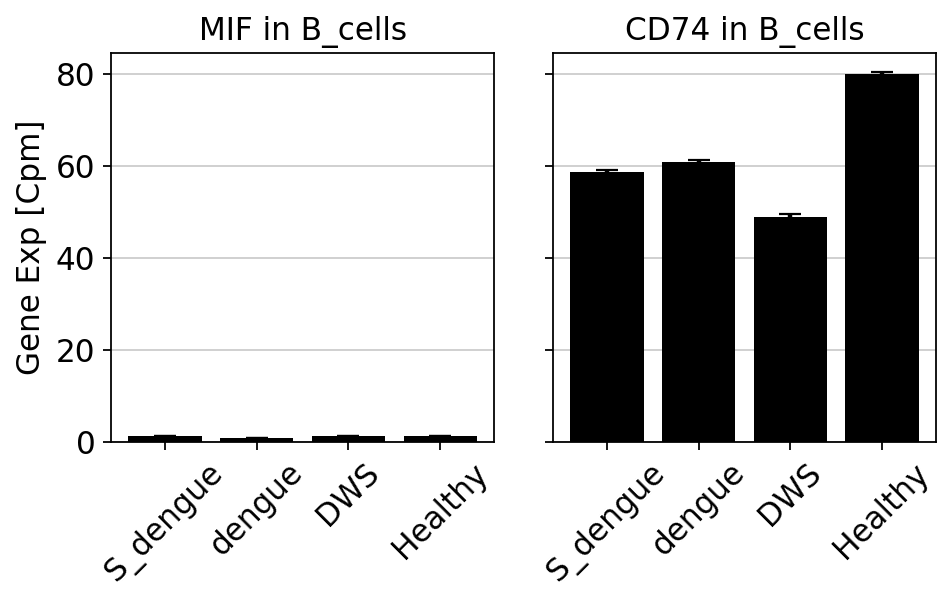

In [48]:
pairs_B=[['MIF','CD74']]
pairs_NK=[]
pairs_T=[]
pairs_Mono=[]
pairs_Plasma=[]
pairs_pDCs=[]
pairs_cDCs=[]
#pairs_cts=[['B_cells','B_cells'],['NK_cells','B_cells'],['T_cells','B_cells'],['Monocytes','B_cells'],['Plasmablasts','B_cells'],['pDCs','B_cells'],['cDCs','B_cells']]
pairs_dic={'B_cells':pairs_B,'NK_cells':pairs_NK,'T_cells':pairs_T, 'Monocytes':pairs_Mono, 
           'Plasmablasts':pairs_Plasma, 'pDCs':pairs_pDCs, 'cDCs':pairs_cDCs}

cell_types=['B_cells','NK_cells','T_cells', 'Monocytes', 'Plasmablasts', 'pDCs', 'cDCs']
adata_dic={}
pairs_cts=[]
for cell_type in cell_types:
    adata_dic[cell_type]=[adata_children_con_ct[('S_dengue',cell_type)],
                                 adata_children_con_ct[('dengue',cell_type)],
                                 adata_children_con_ct[('DWS',cell_type)],
                                adata_children_con_ct[('Healthy',cell_type)]]
    pairs_cts.append([cell_type,'B_cells'])
    
conditions=['S_dengue','dengue','DWS','Healthy']
y_gene_ct=[{},{}]
for ct in pairs_cts:
    pairs=pairs_dic[ct[0]]
    for gene in pairs:
        fig,axs=plt.subplots(1,2,figsize=(6,4),sharey=True)
        for k,(gene_k,ct_k) in enumerate(zip(gene,ct)): 
            y_gene_ct[k][(gene_k,ct_k)]=[]
            x=[0,1,2,3]
            y=[]
            sem_gene_ct=[]
            x_arrow=[0,1,2,3]
            y_arrow=[] 
            for j,condition in enumerate(conditions):
                gene_ct=adata_dic[ct_k][j][:,gene_k].X.toarray()[:,0]
                y_gene_ct[k][(gene_k,ct_k)].append(gene_ct)
                y.append(y_gene_ct[k][(gene_k,ct_k)][j].mean())
                sem_gene_ct.append((y_gene_ct[k][(gene_k,ct_k)][j]).std()/np.sqrt((y_gene_ct[k][(gene_k,ct_k)][j]).size))
                y_arrow.append(y_gene_ct[k][(gene_k,ct_k)][j].mean())
            ax=axs[k]
            ax=sns.barplot(x,y,label='_nolegend_',lw=2,ax=ax,color='black',zorder=10) 
            ax.errorbar(x,y,yerr=sem_gene_ct,color='black',ls='',capsize=5,label='sem',lw=2)
            ax.set_title(gene_k+' in '+ct_k)
            #ax.set_ylim(0,8)
            ax.set_xticklabels(['S_dengue','dengue','DWS','Healthy'],rotation=45)
            #for a in range(3): 
                #ax.arrow(x_arrow[a],y_arrow[a],x_arrow[a+1]-x_arrow[a],y_arrow[a+1]-y_arrow[a],length_includes_head=True,color='red',zorder=10,width=0.1)
            if k==0:
                ax.set_ylabel('Gene Exp [Cpm]') 
        plt.tight_layout()
        plt.subplots_adjust(left=0.1)
        #fig.savefig('/home/yike/phd/dengue/figures/interaction_endo_peri/timepoint/'+gene[0]+' in '+ct[0]+' & '+gene[1]+' in '+ct[1]+'_timepoint.png')